In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("/content/merged_data.csv")

<ipython-input-3-dfdb3120fa48>:1: DtypeWarning: Columns (83) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/merged_data.csv")


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

def process_dates(df):
    df = df.copy()
    print(f"Processing dates for {len(df)} rows")

    df['Date'] = pd.to_datetime(df['Date'], format='mixed', dayfirst=True)

    # Create date features directly
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['Month'] = df['Date'].dt.month
    df['Season'] = df['Date'].dt.year
    df['IsWeekend'] = df['Date'].dt.dayofweek.isin([5,6]).astype(int)

    return df

def handle_missing_values(df):
    df = df.copy()
    print(f"Handling missing values for {len(df)} rows")

    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

    categorical_cols = df.select_dtypes(exclude=[np.number]).columns
    for col in categorical_cols:
        if df[col].isnull().any():
            df[col] = df[col].fillna(df[col].mode().iloc[0])

    return df

def calculate_team_form(df, team_col, result_col, target_result):
    """Calculate form for each team based on their last 5 matches."""
    df = df.sort_values('Date')
    form_dict = {}

    for team in df[team_col].unique():
        # Get matches for this team
        team_matches = df[df[team_col] == team].copy()
        # Calculate rolling form
        form = (team_matches[result_col] == target_result).astype(float).rolling(
            window=5, min_periods=1).mean()
        form_dict[team] = form.values

    return form_dict

def calculate_team_statistics(df):
    df = df.copy()
    print(f"Calculating statistics for {len(df)} rows")

    # Basic statistics
    df['HomeGoalDiff'] = df['FTHG'] - df['FTAG']
    df['HalfTimeGoalDiff'] = df['HTHG'] - df['HTAG']
    df['HomeShotsAccuracy'] = np.where(df['HS'] > 0, df['HST'] / df['HS'], 0)
    df['AwayShotsAccuracy'] = np.where(df['AS'] > 0, df['AST'] / df['AS'], 0)
    df['TotalGoals'] = df['FTHG'] + df['FTAG']
    df['GoalDifference'] = df['FTHG'] - df['FTAG']
    df['TotalShots'] = df['HS'] + df['AS']
    df['ShotsOnTargetDiff'] = df['HST'] - df['AST']

    print("Calculating team forms...")
    # Calculate home and away team forms
    home_forms = calculate_team_form(df, 'HomeTeam', 'FTR', 'H')
    away_forms = calculate_team_form(df, 'AwayTeam', 'FTR', 'A')

    # Apply forms to DataFrame
    df['HomeTeamForm'] = df.apply(
        lambda row: home_forms[row['HomeTeam']][df[df['HomeTeam'] == row['HomeTeam']].index.get_loc(row.name)],
        axis=1
    )

    df['AwayTeamForm'] = df.apply(
        lambda row: away_forms[row['AwayTeam']][df[df['AwayTeam'] == row['AwayTeam']].index.get_loc(row.name)],
        axis=1
    )

    return df

def preprocess_data(df):
    print("Starting preprocessing...")
    print(f"Initial dataframe shape: {df.shape}")

    # Define feature columns
    base_features = [
        'HomeTeamForm', 'AwayTeamForm',
        'HomeShotsAccuracy', 'AwayShotsAccuracy',
        'Month', 'DayOfWeek', 'IsWeekend',
        'HS', 'AS', 'HST', 'AST',
        'HC', 'AC', 'HF', 'AF',
        'HY', 'AY', 'HR', 'AR',
        'TotalGoals', 'GoalDifference',
        'TotalShots', 'ShotsOnTargetDiff'
    ]

    categorical_features = ['HomeTeam', 'AwayTeam']
    betting_features = ['B365H', 'B365D', 'B365A']


    # Process steps
    df = process_dates(df)
    print("Dates processed")

    df = handle_missing_values(df)
    print("Missing values handled")

    df = calculate_team_statistics(df)
    print("Features engineered")

    # Combine available features
    all_features = (base_features +
                    (betting_features if 'B365H' in df.columns else []) +
                    categorical_features)

    available_features = [col for col in all_features if col in df.columns]
    print(f"Features selected: {len(available_features)}")
    print("Available features:", available_features)

    # Create final X and y
    X = df[available_features].copy()
    y = df['FTR'].copy()

    print(f"Final X shape: {X.shape}")
    print(f"Final y shape: {y.shape}")

    return X, y



# Usage example

print("Starting data preprocessing...")
X, y = preprocess_data(df)
print("Preprocessing completed successfully!")

print("\nProcessed dataset information:")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print("\nFeature names:")
print(X.columns.tolist())



Starting data preprocessing...
Starting preprocessing...
Initial dataframe shape: (7260, 159)
Processing dates for 7260 rows
Dates processed
Handling missing values for 7260 rows
Missing values handled
Calculating statistics for 7260 rows
Calculating team forms...
Features engineered
Features selected: 28
Available features: ['HomeTeamForm', 'AwayTeamForm', 'HomeShotsAccuracy', 'AwayShotsAccuracy', 'Month', 'DayOfWeek', 'IsWeekend', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR', 'TotalGoals', 'GoalDifference', 'TotalShots', 'ShotsOnTargetDiff', 'B365H', 'B365D', 'B365A', 'HomeTeam', 'AwayTeam']
Final X shape: (7260, 28)
Final y shape: (7260,)
Preprocessing completed successfully!

Processed dataset information:
Number of samples: 7260
Number of features: 28

Feature names:
['HomeTeamForm', 'AwayTeamForm', 'HomeShotsAccuracy', 'AwayShotsAccuracy', 'Month', 'DayOfWeek', 'IsWeekend', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR', 'Tota

# Match Data Processing Summary

## Initial Data Overview
- **Initial Matches**: 7,260
- **Columns**: 159
- **Processing Status**: All matches successfully processed

---

## Data Processing Steps and Results

1. **Date Processing**
   - Successfully processed date information for all 7,260 rows.

2. **Missing Value Handling**
   - All missing values were managed and handled appropriately.

3. **Statistics Calculation**
   - Successfully generated all relevant statistical features.

4. **Team Form Calculations**
   - Computed team form metrics accurately for all rows.

---

## Final Output Structure

- **Feature Matrix (X)**:
  - Shape: **(7,260 rows, 28 features)**

- **Target Vector (y)**:
  - Shape: **(7,260 rows)**

- **Validation**:
  - All intended features are included in the final dataset.

---

## Generated Features

The features generated cover various aspects of match performance, shooting accuracy, game statistics, and more. These include:

### 1. Performance Metrics
- **HomeTeamForm**: Form of the home team based on recent performances.
- **AwayTeamForm**: Form of the away team based on recent performances.

### 2. Shot Statistics
- **HomeShotsAccuracy**: Accuracy of the home team’s shots.
- **AwayShotsAccuracy**: Accuracy of the away team’s shots.
- **TotalShots**: Total number of shots taken in the match.
- **ShotsOnTargetDiff**: Difference in shots on target between the two teams.

### 3. Game Statistics
- **TotalGoals**: Combined goals scored by both teams in the match.
- **GoalDifference**: Goal difference between the two teams.

### 4. Temporal Features
- **Month**: Month in which the match took place.
- **DayOfWeek**: Day of the week on which the match was played.
- **IsWeekend**: Indicates if the match took place on a weekend.

### 5. Raw Match Data
- **HS**: Home team’s total shots.
- **AS**: Away team’s total shots.
- **HST**: Home team’s shots on target.
- **AST**: Away team’s shots on target.
- **HC**: Home team’s corners.
- **AC**: Away team’s corners.
- **HF**: Home team’s fouls.
- **AF**: Away team’s fouls.
- **HY**: Home team’s yellow cards.
- **AY**: Away team’s yellow cards.
- **HR**: Home team’s red cards.
- **AR**: Away team’s red cards.

### 6. Betting Odds
- **B365H**: Bet365 odds for a home team win.
- **B365D**: Bet365 odds for a draw.
- **B365A**: Bet365 odds for an away team win.

### 7. Team Identifiers
- **HomeTeam**: Identifier for the home team.
- **AwayTeam**: Identifier for the away team.

---


# **This dataset is now fully processed and ready for further analysis or model training, with all necessary features to assess team performance, shot statistics, and game outcomes.**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

def create_temporal_split(X, y, train_size=0.8):

    train_size = int(len(X) * train_size)


    X_train = X.iloc[:train_size]
    X_test = X.iloc[train_size:]
    y_train = y.iloc[:train_size]
    y_test = y.iloc[train_size:]

    print(f"Training set size: {len(X_train)} matches")
    print(f"Test set size: {len(X_test)} matches")

    return X_train, X_test, y_train, y_test

def create_preprocessing_pipeline(X):

    numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

    print("\nFeature types:")
    print(f"Numeric features: {numeric_features}")
    print(f"Categorical features: {categorical_features}")

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'),
             categorical_features)
        ],
        verbose_feature_names_out=True
    )

    return preprocessor


def get_feature_names(preprocessor, X):

    feature_names = preprocessor.get_feature_names_out()

    return feature_names

def process_data(X, y, train_size=0.8):
    """
    Process the data end-to-end, including splitting and preprocessing.
    """
    print("Starting data processing...")


    X_train, X_test, y_train, y_test = create_temporal_split(X, y, train_size)


    preprocessor = create_preprocessing_pipeline(X_train)


    print("\nTransforming features...")
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)


    feature_names = get_feature_names(preprocessor, X_train)


    X_train_processed = pd.DataFrame(
        X_train_processed,
        columns=feature_names,
        index=X_train.index
    )
    X_test_processed = pd.DataFrame(
        X_test_processed,
        columns=feature_names,
        index=X_test.index
    )


    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.transform(y_test)

    print("\nProcessing completed!")
    print(f"Final training set shape: {X_train_processed.shape}")
    print(f"Final test set shape: {X_test_processed.shape}")
    print(f"Number of features after preprocessing: {len(feature_names)}")
    print(f"Target classes: {le.classes_.tolist()}")

    # Save preprocessing objects for later use
    preprocessing_objects = {
        'preprocessor': preprocessor,
        'label_encoder': le,
        'feature_names': feature_names
    }

    return (X_train_processed, X_test_processed,
            y_train_encoded, y_test_encoded,
            preprocessing_objects)


try:
    # Process the data
    (X_train_processed, X_test_processed,
     y_train_encoded, y_test_encoded,
     preprocessing_objects) = process_data(X, y, train_size=0.8)

    # Save preprocessing objects for future use
    joblib.dump(preprocessing_objects, 'preprocessing_objects.joblib')

    print("\nPreprocessing pipeline saved successfully!")

except Exception as e:
    print(f"An error occurred during processing: {str(e)}")
    raise

Starting data processing...
Training set size: 5808 matches
Test set size: 1452 matches

Feature types:
Numeric features: ['HomeTeamForm', 'AwayTeamForm', 'HomeShotsAccuracy', 'AwayShotsAccuracy', 'Month', 'DayOfWeek', 'IsWeekend', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR', 'TotalGoals', 'GoalDifference', 'TotalShots', 'ShotsOnTargetDiff', 'B365H', 'B365D', 'B365A']
Categorical features: ['HomeTeam', 'AwayTeam']

Transforming features...

Processing completed!
Final training set shape: (5808, 108)
Final test set shape: (1452, 108)
Number of features after preprocessing: 108
Target classes: ['A', 'D', 'H']

Preprocessing pipeline saved successfully!


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
# Import necessary libraries
from sklearn.metrics import classification_report
import xgboost as xgb


potential_leakage_features = [
    'GoalDifference',
    'TotalGoals'

]

# Remove potential leakage features
X_train_clean = X_train_processed.drop(columns=[f'num__{col}' for col in potential_leakage_features
                                              if f'num__{col}' in X_train_processed.columns])
X_test_clean = X_test_processed.drop(columns=[f'num__{col}' for col in potential_leakage_features
                                            if f'num__{col}' in X_test_processed.columns])

print("Features removed for leakage prevention:", potential_leakage_features)
print(f"Number of features after removal: {X_train_clean.shape[1]}")

# Define the XGBoost model
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    random_state=42,
    eval_metric='mlogloss'
)

# Train the model
eval_set = [(X_test_clean, y_test_encoded)]
xgb_model.fit(
    X_train_clean,
    y_train_encoded,
    eval_set=eval_set,
    verbose=True
)

# Make predictions
xgb_pred = xgb_model.predict(X_test_clean)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_train_clean.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

# Evaluate model performance
print("\nXGBoost Model Performance:")
print(classification_report(
    y_test_encoded,
    xgb_pred,
    target_names=preprocessing_objects['label_encoder'].classes_
))

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

Features removed for leakage prevention: ['GoalDifference', 'TotalGoals']
Number of features after removal: 106
[0]	validation_0-mlogloss:1.04954
[1]	validation_0-mlogloss:1.00751
[2]	validation_0-mlogloss:0.97271
[3]	validation_0-mlogloss:0.94221
[4]	validation_0-mlogloss:0.91599
[5]	validation_0-mlogloss:0.89334
[6]	validation_0-mlogloss:0.87376
[7]	validation_0-mlogloss:0.85623
[8]	validation_0-mlogloss:0.84036
[9]	validation_0-mlogloss:0.82534
[10]	validation_0-mlogloss:0.81261
[11]	validation_0-mlogloss:0.80124
[12]	validation_0-mlogloss:0.79070
[13]	validation_0-mlogloss:0.78189
[14]	validation_0-mlogloss:0.77323
[15]	validation_0-mlogloss:0.76660
[16]	validation_0-mlogloss:0.75924
[17]	validation_0-mlogloss:0.75302
[18]	validation_0-mlogloss:0.74814
[19]	validation_0-mlogloss:0.74297
[20]	validation_0-mlogloss:0.73878
[21]	validation_0-mlogloss:0.73493
[22]	validation_0-mlogloss:0.73038
[23]	validation_0-mlogloss:0.72710
[24]	validation_0-mlogloss:0.72398
[25]	validation_0-mlogl

Epoch [1/100]
Train Loss: 1.0601, Val Loss: 0.9682
Epoch [2/100]
Train Loss: 0.9335, Val Loss: 0.8427
Epoch [3/100]
Train Loss: 0.8357, Val Loss: 0.7675
Epoch [4/100]
Train Loss: 0.8010, Val Loss: 0.7484
Epoch [5/100]
Train Loss: 0.7887, Val Loss: 0.7410
Epoch [6/100]
Train Loss: 0.7855, Val Loss: 0.7363
Epoch [7/100]
Train Loss: 0.7805, Val Loss: 0.7321
Epoch [8/100]
Train Loss: 0.7801, Val Loss: 0.7303
Epoch [9/100]
Train Loss: 0.7749, Val Loss: 0.7268
Epoch [10/100]
Train Loss: 0.7711, Val Loss: 0.7246
Epoch [11/100]
Train Loss: 0.7707, Val Loss: 0.7195
Epoch [12/100]
Train Loss: 0.7724, Val Loss: 0.7232
Epoch [13/100]
Train Loss: 0.7742, Val Loss: 0.7349
Epoch [14/100]
Train Loss: 0.7689, Val Loss: 0.7226
Epoch [15/100]
Train Loss: 0.7660, Val Loss: 0.7225
Epoch [16/100]
Train Loss: 0.7688, Val Loss: 0.7207
Early stopping triggered


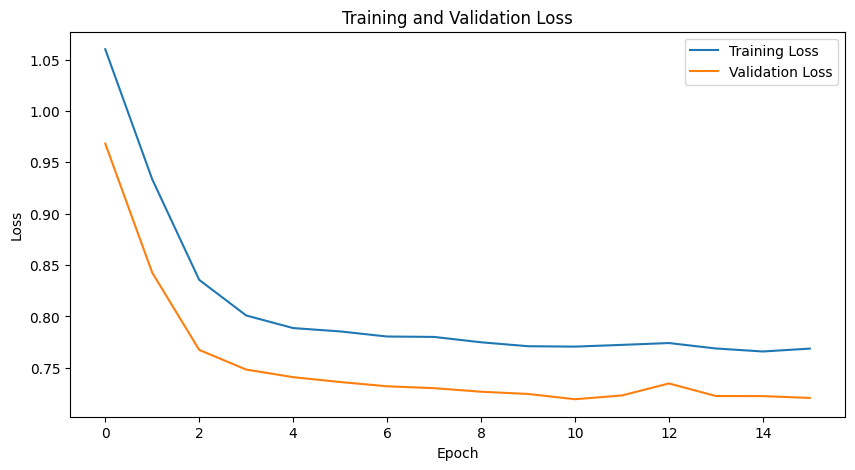


LSTM Model Performance:
              precision    recall  f1-score   support

           A       0.67      0.80      0.73       428
           D       0.53      0.22      0.31       360
           H       0.72      0.86      0.78       660

    accuracy                           0.68      1448
   macro avg       0.64      0.63      0.61      1448
weighted avg       0.66      0.68      0.65      1448



In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Updated Model Parameters
sequence_length = 5
batch_size = 64  # Adjusted batch size
input_size = X_train_lstm.shape[1]
hidden_size = 64  # Reduced hidden size to simplify model
num_layers = 1  # Reduced number of layers
num_classes = len(preprocessing_objects['label_encoder'].classes_)
num_epochs = 100
learning_rate = 0.0005  # Lower learning rate for better convergence
dropout_rate = 0.5  # Increased dropout rate for regularization
weight_decay = 0.01  # L2 regularization

# Define Dataset Class
class MatchSequenceDataset(Dataset):
    def __init__(self, features, targets, sequence_length):
        self.features = torch.FloatTensor(features.values)
        self.targets = torch.LongTensor(targets)
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.features) - self.sequence_length + 1

    def __getitem__(self, idx):
        sequence = self.features[idx:idx + self.sequence_length]
        target = self.targets[idx + self.sequence_length - 1]
        return sequence, target

# Define LSTM Model
class LSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.2):
        super(LSTMPredictor, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, num_classes)
        )

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Define Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, patience=5):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        for sequences, labels in train_loader:
            sequences = sequences.to(device)
            labels = labels.to(device)

            outputs = model(sequences)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        # Validation phase
        model.eval()
        total_val_loss = 0
        val_predictions = []
        val_true_labels = []

        with torch.no_grad():
            for sequences, labels in val_loader:
                sequences = sequences.to(device)
                labels = labels.to(device)

                outputs = model(sequences)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                val_predictions.extend(predicted.cpu().numpy())
                val_true_labels.extend(labels.cpu().numpy())

        # Calculate average losses
        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

    return train_losses, val_losses, val_predictions, val_true_labels

# Prepare Datasets and Dataloaders
train_dataset = MatchSequenceDataset(X_train_lstm, y_train_encoded, sequence_length)
test_dataset = MatchSequenceDataset(X_test_lstm, y_test_encoded, sequence_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize Model, Loss, and Optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_model = LSTMPredictor(input_size, hidden_size, num_layers, num_classes, dropout=dropout_rate).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Train the Model
train_losses, val_losses, val_predictions, val_true_labels = train_model(
    lstm_model, train_loader, test_loader, criterion, optimizer, num_epochs, device
)

# Plot Losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Print Classification Report
print("\nLSTM Model Performance:")
print(classification_report(
    val_true_labels,
    val_predictions,
    target_names=preprocessing_objects['label_encoder'].classes_
))


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV

# First, let's create interaction features and temporal features
def create_advanced_features(df):
    # Create temporal features
    df['Date'] = pd.to_datetime(df['Date'])
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['Month'] = df['Date'].dt.month
    df['Season'] = np.where(df['Month'].isin([8,9,10,11,12]), 'Early',
                           np.where(df['Month'].isin([1,2,3]), 'Mid', 'Late'))

    # Create interaction features
    df['GoalRatio'] = df['FTHG'] / df['FTAG'].replace(0, 0.1)
    df['TotalGoals'] = df['FTHG'] + df['FTAG']
    df['GoalDifference'] = df['FTHG'] - df['FTAG']

    return df

# Feature selection using RFE
def perform_feature_selection(X, y, n_features_to_select=20):
    model = xgb.XGBClassifier()
    rfe = RFE(estimator=model, n_features_to_select=n_features_to_select)
    X_selected = rfe.fit_transform(X, y)
    selected_features = X.columns[rfe.support_]
    return X_selected, selected_features


def preprocess_with_smote(X_train, X_test, y_train, y_test):
    # Standard scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

    return X_train_balanced, X_test_scaled, y_train_balanced, y_test

# Hyperparameter tuning
def tune_xgboost_hyperparameters(X_train, y_train):
    param_grid = {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1],
        'n_estimators': [100, 200],
        'min_child_weight': [1, 3],
        'gamma': [0, 0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }

    xgb_model = xgb.XGBClassifier(objective='multi:softprob', eval_metric='mlogloss')
    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        cv=5,
        scoring='f1_weighted',
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)
    return grid_search.best_params_

# Main training pipeline
def train_and_evaluate_model(X_train_balanced, X_test_scaled, y_train_balanced, y_test):

    best_params = tune_xgboost_hyperparameters(X_train_balanced, y_train_balanced)


    model = xgb.XGBClassifier(
        objective='multi:softprob',
        eval_metric='mlogloss',
        **best_params
    )


    cv_scores = cross_val_score(
        model,
        X_train_balanced,
        y_train_balanced,
        cv=5,
        scoring='f1_weighted'
    )

    # Train final model
    model.fit(X_train_balanced, y_train_balanced)

    # Make predictions
    y_pred = model.predict(X_test_scaled)

    return model, y_pred, cv_scores


X_train_clean = X_train_processed.drop(columns=[f'num__{col}' for col in potential_leakage_features
                                              if f'num__{col}' in X_train_processed.columns])
X_test_clean = X_test_processed.drop(columns=[f'num__{col}' for col in potential_leakage_features
                                            if f'num__{col}' in X_test_processed.columns])

# Apply preprocessing with SMOTE
X_train_balanced, X_test_scaled, y_train_balanced, y_test = preprocess_with_smote(
    X_train_clean, X_test_clean, y_train_encoded, y_test_encoded
)


model, predictions, cv_scores = train_and_evaluate_model(
    X_train_balanced, X_test_scaled, y_train_balanced, y_test
)


print("\nCross-validation scores:", cv_scores)
print("Average CV score:", cv_scores.mean())
print("\nModel Performance on Test Set:")
print(classification_report(
    y_test,
    predictions,
    target_names=preprocessing_objects['label_encoder'].classes_
))


feature_importance = pd.DataFrame({
    'feature': X_train_clean.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


Cross-validation scores: [0.63467224 0.6215732  0.58595471 0.77950441 0.73866768]
Average CV score: 0.6720744480798738

Model Performance on Test Set:
              precision    recall  f1-score   support

           A       0.69      0.74      0.71       429
           D       0.48      0.42      0.45       360
           H       0.77      0.78      0.78       663

    accuracy                           0.68      1452
   macro avg       0.65      0.65      0.65      1452
weighted avg       0.67      0.68      0.68      1452


Top 10 Most Important Features:
                      feature  importance
1           num__AwayTeamForm    0.065116
0           num__HomeTeamForm    0.056251
17                    num__HR    0.014886
56        cat__HomeTeam_Stoke    0.013117
20     num__ShotsOnTargetDiff    0.012933
58      cat__HomeTeam_Swansea    0.012914
18                    num__AR    0.012486
47  cat__HomeTeam_Middlesboro    0.011731
74     cat__AwayTeam_Charlton    0.011588
51   cat__Home